This code is slightly modified version of "Machine Learning - Account based - Deep Learning" from the repo https://github.com/warproxxx/Twitter-Bot-or-Not?tab=readme-ov-file. This was to test and see if the model still worked and make any necersary changes to get model functional for future work.

This first section is simply loading the model and getting a summary of it, as well as some imports used later.

In [59]:
import tensorflow as tf

import pandas as pd
import numpy as np
import math

from keras.layers import Embedding, Dense, LSTM, Dense, Input, concatenate
from keras.models import Model
from keras.utils import plot_model

from keras.preprocessing.sequence import pad_sequences

In [61]:
loaded_model = tf.keras.models.load_model('my_model.h5', compile=False)

In [63]:
loaded_model.load_weights('my_model.h5')

In [65]:
loaded_model.compile(
    optimizer='adam', 
    loss='binary_crossentropy', 
    metrics=['accuracy']
)

In [67]:
loaded_model.summary()

Model: "model_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_1 (InputLayer)            │ (None, 10)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 500)            │         5,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 200)            │       100,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           201 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 105,901 (413.68 KB)

 Trainable params: 105,901 (413.68 KB)

 Non-trainable params: 0 (0.00 B)

This section required slight modification to how age was calculated to get it running without error. It also required two new imports.

In [70]:
import datetime
from pytz import timezone

In [72]:
bot_accounts = pd.concat([pd.read_csv('data/social_spambots_1.csv'), pd.read_csv('data/social_spambots_2.csv'), pd.read_csv('data/social_spambots_3.csv')]).reset_index(drop=True)
clean_accounts = pd.read_csv('data/geniune_accounts.csv')

requiredColumns = ['screen_name', 'created_at', 'updated', 'location', 'verified', 'statuses_count', 'friends_count','followers_count', 'favourites_count', 'default_profile_image', 'profile_use_background_image', 'protected', 'default_profile']
bot_accounts = bot_accounts[requiredColumns]
clean_accounts = clean_accounts[requiredColumns]

def clean_df(df):
    df['created_at'] = pd.to_datetime(df['created_at'])
    df['updated'] = pd.to_datetime(df['updated'])
    #print(df['updated'])
    #print()
    #print(df['created_at'])
    df['age'] = ((df['updated'].dt.tz_localize('UTC') - df['created_at']) / np.timedelta64(1, 'D')).astype('int') #modified this line from original repo code.
    #df['age'] = (df['updated'].dt.tz_localize('UTC') - df['created_at']).astype('timedelta64[D]').astype(int)
    #print(df['age'])
    df['has_location'] = df['location'].apply(lambda x: 0 if x==x else 1)
    df['has_avatar'] = df['default_profile_image'].apply(lambda x: 1 if x==x else 0)
    df['has_background'] = df['profile_use_background_image'].apply(lambda x: 1 if x==x else 0)
    df['is_verified']=df['verified'].apply(lambda x: 1 if x==x else 0)
    df['is_protected']=df['protected'].apply(lambda x: 1 if x==x else 0)
    df['profile_modified'] = df['default_profile'].apply(lambda x: 0 if x==x else 1)
    df = df.rename(index=str, columns={"screen_name": "username", "statuses_count": "total_tweets", "friends_count": "total_following", "followers_count": "total_followers", "favourites_count": "total_likes"})
    return df[['username', 'age', 'has_location', 'is_verified', 'total_tweets', 'total_following', 'total_followers', 'total_likes', 'has_avatar', 'has_background', 'is_protected', 'profile_modified']]

bot_accounts = clean_df(bot_accounts)
clean_accounts = clean_df(clean_accounts)

C:\Users\lukez\AppData\Local\Temp\ipykernel_28792\3117387048.py:9: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['created_at'] = pd.to_datetime(df['created_at'])
C:\Users\lukez\AppData\Local\Temp\ipykernel_28792\3117387048.py:9: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['created_at'] = pd.to_datetime(df['created_at'])


No Changes neccersary from original repo.

In [74]:
bot_accounts['BotOrNot'] = 1
clean_accounts['BotOrNot'] = 0

combined_df = pd.concat([bot_accounts, clean_accounts])

new_df = combined_df.sample(frac=1).reset_index(drop=True)

In [75]:
training_df = new_df.drop('username', axis=1)[:int(combined_df.shape[0] * 0.8)]
test_df = new_df.drop('username', axis=1)[int(combined_df.shape[0] * 0.8):]

columns_to_standardize = ['age', 'total_tweets', 'total_following', 'total_followers', 'total_likes']

training_df_mean = training_df[columns_to_standardize].mean()
training_df_std = training_df[columns_to_standardize].std()

training_df[columns_to_standardize] = (training_df[columns_to_standardize] - training_df_mean)/training_df_std
test_df[columns_to_standardize] = (test_df[columns_to_standardize] - training_df_mean)/training_df_std


Added code to plot the skew of the data to better understand the data.

botlable: 2790    personlable: 3918


Text(0.5, 1.0, 'Ratio of training data')

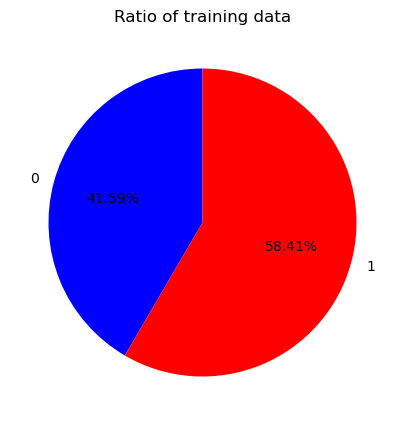

In [77]:
import matplotlib.pyplot as plt
import seaborn as sns

# Pie chart, where the slices will be ordered and plotted counter-clockwise:
labels = {0, 1}
sizes = [len(training_df[training_df.BotOrNot==0]), len(training_df[training_df.BotOrNot==1])]

print("botlable:", len(training_df[training_df.BotOrNot==0]), "   personlable:", len(training_df[training_df.BotOrNot==1]))

fig1, ax1 = plt.subplots(figsize = (5,5))
ax1.pie(sizes, labels=labels, autopct='%1.2f%%', 
        startangle=90,
        colors=['b','r'])

#ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

text =  'Ratio of training data'
ax1.set_title(text)

botlable: 684    personlable: 994


Text(0.5, 1.0, 'Ratio of testing data')

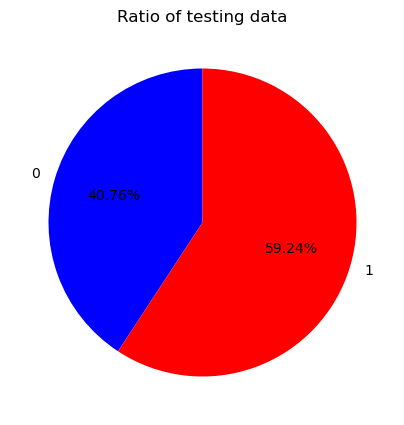

In [79]:
# Pie chart, where the slices will be ordered and plotted counter-clockwise:
labels = {0, 1}
sizes = [len(test_df[test_df.BotOrNot==0]), len(test_df[test_df.BotOrNot==1])]

print("botlable:", len(test_df[test_df.BotOrNot==0]), "   personlable:", len(test_df[test_df.BotOrNot==1]))

fig1, ax1 = plt.subplots(figsize = (5,5))
ax1.pie(sizes, labels=labels, autopct='%1.2f%%', 
        startangle=90,
        colors=['b','r'])

#ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

text =  'Ratio of testing data'
ax1.set_title(text)

Back to code from the repo. No changes neccesary.

In [85]:
X_train = training_df.drop(['BotOrNot', 'is_protected'], axis=1).values
y_train = training_df['BotOrNot'].values.reshape(-1,1)

X_test = test_df.drop(['BotOrNot', 'is_protected'], axis=1).values
y_test = test_df['BotOrNot'].values.reshape(-1,1)

In [87]:
training = loaded_model.fit(x=X_train, y=y_train, batch_size=64, epochs=20, validation_data=(X_test, y_test))

Epoch 1/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9788 - loss: 0.0768 - val_accuracy: 0.9762 - val_loss: 0.0744
Epoch 2/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9798 - loss: 0.0665 - val_accuracy: 0.9750 - val_loss: 0.0711
Epoch 3/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9783 - loss: 0.0679 - val_accuracy: 0.9779 - val_loss: 0.0809
Epoch 4/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9811 - loss: 0.0590 - val_accuracy: 0.9779 - val_loss: 0.0839
Epoch 5/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9799 - loss: 0.0622 - val_accuracy: 0.9785 - val_loss: 0.0700
Epoch 6/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9829 - loss: 0.0557 - val_accuracy: 0.9779 - val_loss: 0.0677
Epoch 7/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9819 - loss: 0.0576 - val_accuracy: 0.9797 - val_loss: 0.0798
Epoch 8/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9840 - loss: 0.0510 - val_accuracy: 0.

After this the rest of the code is me evaluating the model and getting results.

In [89]:
results = loaded_model.evaluate(X_test, y_test)
print("test loss, test acc:", results)

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9705 - loss: 0.0844  
test loss, test acc: [0.07728076726198196, 0.9767580628395081]


In [90]:
prediction = loaded_model.predict(X_test).ravel()

print(prediction)
print(y_test.ravel())

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
[0.9999778  0.99997634 0.99997354 ... 0.99483854 0.99997514 0.9999746 ]
[1 1 1 ... 1 1 1]


In [91]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn import metrics
print(y_test.ravel())
fpr, tpr, _ = metrics.roc_curve(y_test.ravel(), prediction)

[1 1 1 ... 1 1 1]


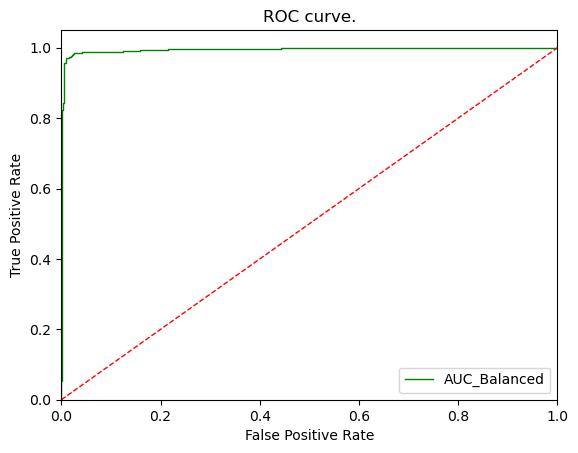

In [92]:
plt.plot(
    fpr,
    tpr,
    color= "g",
    lw=1,
    label= "AUC_Balanced",
)
plt.plot([0, 1], [0, 1], color="r", lw=1, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC curve.")
plt.legend(loc="lower right")
plt.show()